# NERF for LDDMM registration

Here let's try to use NERF to generate time-dependent velocity fields, and integrate using LDDMM. The NERF is used to generate a 2D+time velocity field $v(\mathbf{x},t)$, which should be a smooth function. The velocity field is integrated by approximately solving the flow equation:

$$
\frac{\partial \phi }{\partial t}(\mathbf{x},t) = v(\phi(\mathbf{x},t), t) \qquad \phi(\mathbf{x}, 0) = \mathbf{x}
$$

The velocity field is expected to be smooth. The optimization involves a regularlization term that penalizes the non-smoothness and magnitude of the velocity field, like in [classic LDDMM](http://dx.doi.org/10.1023/B:VISI.0000043755.93987.aa)


In [23]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection

matplotlib.rcParams['figure.facecolor'] = 'white'

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


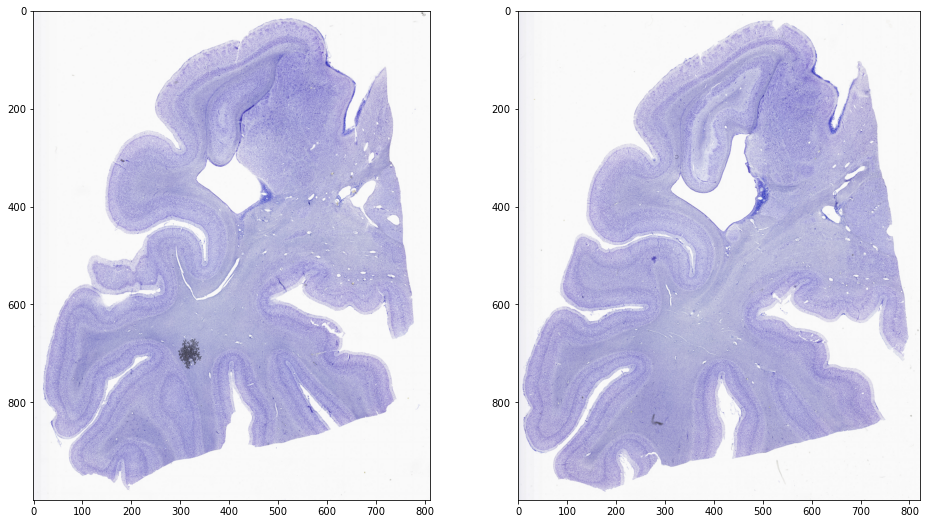

In [25]:
# Read our two images
img_a = sitk.ReadImage('data/slide_4431_x16_1000.tiff')
img_b = sitk.ReadImage('data/slide_4434_x16_1000.tiff')

fig, ax = plt.subplots(1, 2, figsize=(16,9))
ax[0].imshow(sitk.GetArrayFromImage(img_a))
ax[1].imshow(sitk.GetArrayFromImage(img_b));

In [38]:
# Convert the images to tensors
T_fix = torch.tensor(sitk.GetArrayFromImage(img_a), device=device, dtype=torch.float32)
T_fix = T_fix.permute(2,0,1)[None,:,:,:]
T_fix = T_fix / 255.0

T_mov = torch.tensor(sitk.GetArrayFromImage(img_b), device=device, dtype=torch.float32)
T_mov = T_mov.permute(2,0,1)[None,:,:,:]
T_mov = T_mov / 255.0

In [39]:
# Create a network that maps coordinate (x,y) and time value t to a 
# velocity vector (vx, vy)
class MyNerfLDDMM(torch.nn.Module):

    def __init__(self, enc_size=5, depth=4, width=128):
        super().__init__()

        # Construct the sinusoidal encoder weights
        self.register_buffer('omega', 2**torch.arange(enc_size) * torch.pi)

        # Create an MLP
        self.mlp = torch.nn.Sequential()
        self.mlp.add_module('dense_0', torch.nn.Linear(enc_size * 4 + 3, width))
        self.mlp.add_module('relu_0', torch.nn.ReLU())

        for i in range(1, depth-1):
            self.mlp.add_module(f'dense_{i}', torch.nn.Linear(width, width))
            self.mlp.add_module(f'relu_{i}', torch.nn.ReLU())

        self.mlp.add_module(f'dense_{depth-1}', torch.nn.Linear(width, 2))

    def forward(self, x, t):

        # Turn t into a tensor
        tt = torch.ones([x.shape[0]], dtype=x.dtype, device=x.device) * t

        # Apply sine encoding to x
        omega = self.get_buffer('omega')
        z = torch.einsum('i,jk->jki', omega, x)

        # Note that here we add the time parameter to the network
        y = torch.cat([tt[:,None], x, torch.flatten(torch.sin(z), 1), torch.flatten(torch.cos(z), 1)], 1)

        # Pass through MLP
        return self.mlp(y)


In [40]:
nerf = MyNerfLDDMM(enc_size=6, depth=6, width=256)
nerf.to(device)

MyNerfLDDMM(
  (mlp): Sequential(
    (dense_0): Linear(in_features=27, out_features=256, bias=True)
    (relu_0): ReLU()
    (dense_1): Linear(in_features=256, out_features=256, bias=True)
    (relu_1): ReLU()
    (dense_2): Linear(in_features=256, out_features=256, bias=True)
    (relu_2): ReLU()
    (dense_3): Linear(in_features=256, out_features=256, bias=True)
    (relu_3): ReLU()
    (dense_4): Linear(in_features=256, out_features=256, bias=True)
    (relu_4): ReLU()
    (dense_5): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [41]:
# Try to perform image registration
opt = torch.optim.Adam(nerf.parameters(), lr=1e-3)
loss = torch.nn.MSELoss(reduction='mean')

In [42]:
# Generate a sampling grid for mini-batches
id_affine = torch.tensor([[[1,0,0],[0,1,0]]],dtype=torch.float32, device=device)
grid = F.affine_grid(id_affine, T_fix.shape, align_corners=False)
grid_flat = grid.permute(0,3,1,2).flatten(2).permute(0,2,1).squeeze()
grid_flat = (grid_flat + 1.0) / 2.0
grid_flat = grid_flat.to(device)

# Get the target rgb intensities
rgb_flat = T_fix.flatten(2).permute(0,2,1).squeeze()

In [43]:
# Generate the offsets for computing derivatives of v. Here we use the
# central difference approximation of the Laplacian operator
eps_x, eps_y = (1.0 / x for x in T_fix.shape[2:])
off_x = torch.tensor([[eps_x,0]], dtype=torch.float32, device=device)
off_y = torch.tensor([[0,eps_y]], dtype=torch.float32, device=device)

# Number of time steps and time epsilon
nt = 10
eps_t = 1.0 / nt

# Weights of the regularization terms (see Beg paper)
alpha, gamma = 0.0005, 0.00001

# Batch size: number of coordinates passed through the network
batch_size = 10000

# This function integrates the velocity field and computes the sobolev norm 
# of the velocity field along the trajectory
def lddmm_flow(x):
    sobolev_norm = 0
    for t in range(nt):
        # Stack phi and the adjacent coordinates into one input vector and pass to the network
        inp = torch.cat([x, x - off_x, x + off_x, x - off_y, x + off_y], 0)
        out = nerf.forward(inp, t).reshape(5,-1,2)

        # Compute the velocity at x and the Laplacian of the velocity at x
        vt = out[0, :]
        lap_vt = (out[1,:,:] + out[2,:,:] - 2 * vt) / eps_x ** 2 + (out[3,:,:] + out[4,:,:] - 2 * vt) / eps_y ** 2;

        # This is the term g() in (17) of Beg et al.
        g = gamma * vt - alpha * lap_vt
        sobolev_norm += torch.sum(g ** 2) / (nt * x.shape[0])

        # Perform forward integration
        x = x + eps_t * vt

    return x, sobolev_norm

# History for the different parts of the objective function
history = { 'l2': [], 'reg': [], 'total': []}

# Iterate over epochs
for epoch in range(20):

    # Shuffle the grid to determine random sampling order
    epoch_idx = torch.randperm(grid_flat.shape[0])

    # Determine the indices for each minibatch
    batch_ranges = np.linspace(0, epoch_idx.shape[0], int(epoch_idx.shape[0] / batch_size), dtype=np.int32)

    # Clear loss history
    for k in history.keys():
        history[k].append(0)

    # Iterate over the mini-batches       
    for i in range(len(batch_ranges) - 1):

        # Start Adam iteration
        opt.zero_grad()

        # Get the image coordinates sampled in the current mini-batch
        mb_idx = epoch_idx[batch_ranges[i]:batch_ranges[i+1]]

        # Perform flow and get the regularization loss value
        x, sobolev_norm = lddmm_flow(grid_flat[mb_idx,:])

        # Get the fixed image intensities at this sample
        rgb_fix = rgb_flat[mb_idx,:]

        # Get the moving image intensities by interpolation
        rgb_mov = F.grid_sample(T_mov, x[:,:,None,None].permute(2,0,3,1) * 2.0 - 1.0, align_corners=False).squeeze().T

        # Compute loss and backprop
        l2_loss = loss(rgb_fix, rgb_mov)
        obj = l2_loss + sobolev_norm
        
        # Backpropagation
        obj.backward()
        opt.step()

        # Track epoch loss
        history['l2'][-1] += l2_loss.item() * len(mb_idx) / len(epoch_idx)
        history['reg'][-1] += sobolev_norm.item() * len(mb_idx) / len(epoch_idx)
        history['total'][-1] += obj.item() * len(mb_idx) / len(epoch_idx)

    # Report the epoch loss
    print(f'Epoch {epoch:04d}   L2 Loss: {history["l2"][-1]:8.6f}    Reg: {history["reg"][-1]:8.6f}    Total: {history["total"][-1]:8.6f}')




Epoch 0000   L2 Loss: 0.012007    Reg: 0.001180    Total: 0.013187
Epoch 0001   L2 Loss: 0.006212    Reg: 0.000287    Total: 0.006499
Epoch 0002   L2 Loss: 0.005847    Reg: 0.000288    Total: 0.006135
Epoch 0003   L2 Loss: 0.005750    Reg: 0.000269    Total: 0.006019
Epoch 0004   L2 Loss: 0.005489    Reg: 0.000283    Total: 0.005772
Epoch 0005   L2 Loss: 0.005364    Reg: 0.000277    Total: 0.005640
Epoch 0006   L2 Loss: 0.005083    Reg: 0.000296    Total: 0.005379
Epoch 0007   L2 Loss: 0.005293    Reg: 0.000324    Total: 0.005617
Epoch 0008   L2 Loss: 0.004966    Reg: 0.000353    Total: 0.005319
Epoch 0009   L2 Loss: 0.004973    Reg: 0.000372    Total: 0.005345
Epoch 0010   L2 Loss: 0.005023    Reg: 0.000231    Total: 0.005255
Epoch 0011   L2 Loss: 0.004817    Reg: 0.000312    Total: 0.005129
Epoch 0012   L2 Loss: 0.004699    Reg: 0.000319    Total: 0.005018
Epoch 0013   L2 Loss: 0.004550    Reg: 0.000306    Total: 0.004857
Epoch 0014   L2 Loss: 0.004547    Reg: 0.000313    Total: 0.00

In [44]:
# Perform inference - we need a full grid of x
with torch.no_grad():
    phi, _ = lddmm_flow(grid_flat)

# Resample the moving image
rgb_mov = F.grid_sample(T_mov, phi[:,:,None,None].permute(2,0,3,1) * 2.0 - 1.0, align_corners=False).squeeze().T

# Turn it into a SimpleITK image
resliced = rgb_mov.reshape(1,T_fix.shape[2], T_fix.shape[3], 3).detach().cpu().numpy()
resliced = np.clip(resliced[0,:,:,:], 0., 1.)
img_resliced = sitk.GetImageFromArray(resliced, isVector=True)
img_resliced.CopyInformation(img_a)

# Get the deformation in the form of a grid for plotting
phi_grid = phi.reshape(1,T_fix.shape[2], T_fix.shape[3], 2).squeeze().detach().cpu().numpy()

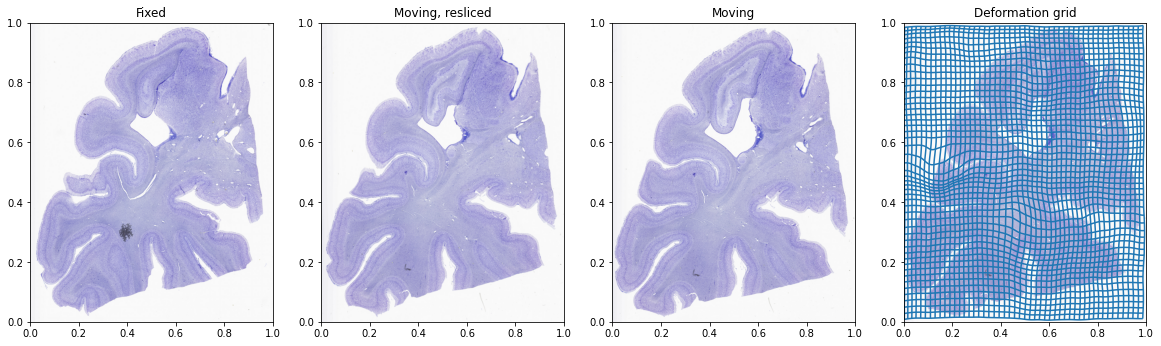

In [45]:
# Plot the images and the grid
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    segs1 = segs1[np.linspace(0, segs1.shape[0]-1, 50, dtype=np.int32), :, :]
    ax.add_collection(LineCollection(segs1, **kwargs))
    segs2 = segs2[np.linspace(0, segs2.shape[0]-1, 50, dtype=np.int32), :, :]
    ax.add_collection(LineCollection(segs2, **kwargs))

fig, ax = plt.subplots(1, 4, figsize=(20,9))
aspect = img_a.GetSize()[1] / img_a.GetSize()[0]
ax[0].imshow(sitk.GetArrayFromImage(img_a), extent=[0, 1, 0, 1], aspect=aspect)
ax[0].set_title('Fixed')
ax[1].imshow(sitk.GetArrayFromImage(img_resliced), extent=[0, 1, 0, 1], aspect=aspect)
ax[1].set_title('Moving, resliced')
ax[2].imshow(sitk.GetArrayFromImage(img_b), extent=[0, 1, 0, 1], aspect=aspect)
ax[2].set_title('Moving')
ax[3].imshow(sitk.GetArrayFromImage(img_b), extent=[0, 1, 0, 1], aspect=aspect) 
plot_grid(phi_grid[:,:,0], phi_grid[:,:,1], ax[3])
ax[3].set_title('Deformation grid');

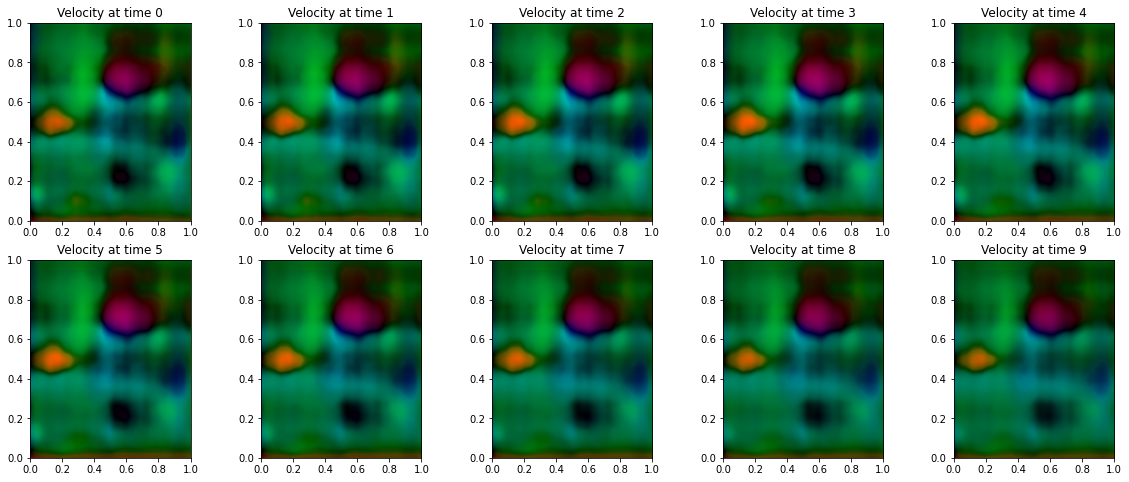

In [55]:
# Finally, it is nice to plot the velocity field. We can plot it using color
# with value equal to the magnitude of velocity and hue to the direction
with torch.no_grad():
    v = np.stack([
        nerf.forward(grid_flat, t).reshape(1,T_fix.shape[2], T_fix.shape[3], 2).squeeze().detach().cpu().numpy()
        for t in range(nt)],0)
    
# Convert velocity to RGB
mag_v = np.sqrt(np.sum(v**2, axis=3))
mag_v = mag_v / np.max(mag_v)
phase_v = np.arctan2(v[:,:,:,0],v[:,:,:,1]) / (2*np.pi) + 0.5
v_hsv = np.stack([phase_v, phase_v * 0. + 1., mag_v], axis=3)
v_rgb = colors.hsv_to_rgb(v_hsv)

# Plot
fix, ax = plt.subplots(2, nt//2, figsize=(20,8))
ax = ax.flatten()
for t in range(nt):
    ax[t].imshow(v_rgb[t,:,:,:], extent=[0, 1, 0, 1], aspect=aspect)
    ax[t].set_title(f'Velocity at time {t}')